# Машинное обучение, ММП ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 09.12.2019

Мягкий дедлайн: 23:59MSK 22.12.2019

Жесткий дедлайн: 23:59MSK 29.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

## Часть 1. Bias-Variance Decomposition

In [156]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [157]:
from sklearn.datasets import load_boston

In [158]:
boston = load_boston()

In [159]:
X = boston["data"]
y = boston["target"]

In [160]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.919015671821775

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [43]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    
    ans_sum = np.zeros(X.shape[0], dtype=np.float64)
    ans_sq_sum = np.zeros(X.shape[0], dtype=np.float64)
    has_ans = np.zeros(X.shape[0], dtype=bool)
    encountered = np.zeros(X.shape[0], dtype=np.int64)
    mse_error = 0
    n_oub = 0
    
    
    for i in range(num_runs):
        idxes = np.random.randint(X.shape[0], size=X.shape[0])
        X_b_train = X[idxes]
        y_b_train = y[idxes]
        
        mask = np.ones(X.shape[0], dtype=bool)
        mask[idxes] = False
        X_b_test = X[mask]
        y_b_test = y[mask]
        
        regressor.fit(X_b_train, y_b_train)
        y_pred = regressor.predict(X_b_test)
        
        has_ans[mask] = True
        ans_sum[mask] += y_pred
        ans_sq_sum[mask] += (y_pred ** 2)
        encountered[mask] += 1
        
        mse_error += ((y_b_test - y_pred) ** 2).sum()
        n_oub += mask.sum()
    
    bias = ((y[has_ans] - (ans_sum[has_ans] / encountered[has_ans])) ** 2).mean()
    variance = ((ans_sq_sum[has_ans] / encountered[has_ans]) - (ans_sum[has_ans] / encountered[has_ans]) ** 2).mean()
    
    return bias, variance, mse_error / n_oub

**Задание 2. (1 балл)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [46]:
compute_biase_variance(LinearRegression(), X, y)

(23.810805374053796, 0.9610126666917852, 24.592296024681367)

In [47]:
compute_biase_variance(DecisionTreeRegressor(), X, y)

(10.489426538754744, 13.244673487856463, 23.704701345223913)

In [161]:
compute_biase_variance(RandomForestRegressor(), X, y)

C:\conda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(10.526319033896478, 3.4397525373152242, 14.031052323941395)

Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here: да. Как мы видим, несмотря на то что MSE для линейной регресии и решающего дерева почти одинаковая, она разлагается на разные компоненты. У линейной регресии большое смещение, что поскольку эта модель недостаточно сложная, чтобы найти зависимости в данных, но маленький разброс. А дерево является гораздо более гибкой моделью, поэтому её смещение гораздо меньше, но выше разброс. Эта проблема решается использованием решающего леса, у которого смещение такое же, как у дерева, но намного меньше разброс (из-за бутстрапа и рандомизации в вершинах деревьев).__

Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here: в теории, при генерации m выборок с помощью бутстрапа, обучения на них m алгоритмов и усреднении ответов, разброс должен уменьшиться в m раз. Сравним модели решающего дерева и случайного леса (случайный лес - это бэггинг над решающими деревьями, с некоторыми улучшениями, например, рандомизацией в вершинах). По умолчанию в случайном лесе 10 деревьев, но разброс уменьшился в 4 раза, а не в 10. Попробуем увеличить число деревьев.__

In [162]:
compute_biase_variance(RandomForestRegressor(n_estimators=100), X, y)

(10.62500981224606, 2.228969665614775, 12.763812102724206)

__(Продолжение ответа): как видим, увеличение ещё в 10 раз количества деревьев не уменьшило ещё в 10 раз разброс. Это можно объяснить тем, что мы генерируем выборки из другой, достаточно сильно ограниченной выборки (около 500 объектов). В связи с этим модели получаются не совсем независимыми.__

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [52]:
from sklearn.model_selection import train_test_split

In [152]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=10)
    answers = np.zeros((num_test_objects, num_runs))
    
    for i in range(num_runs):
        idxes = np.random.randint(X_train.shape[0], size=X_train.shape[0])
        X_b_train = X_train[idxes]
        y_b_train = y_train[idxes]
        
        regressor.fit(X_b_train, y_b_train)
        y_pred = regressor.predict(X_test)
        answers[:, i] = y_pred
    
    plt.title(title)
    plt.ylabel('Ответы алгоритма')
    plt.xlabel('Объекты')
    plt.ylim((0, 55))
    for i in range(num_test_objects):
        plt.scatter([i] * num_runs, answers[i], c='red')
        plt.scatter([i], [y_test[i]], c='black')

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

C:\conda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


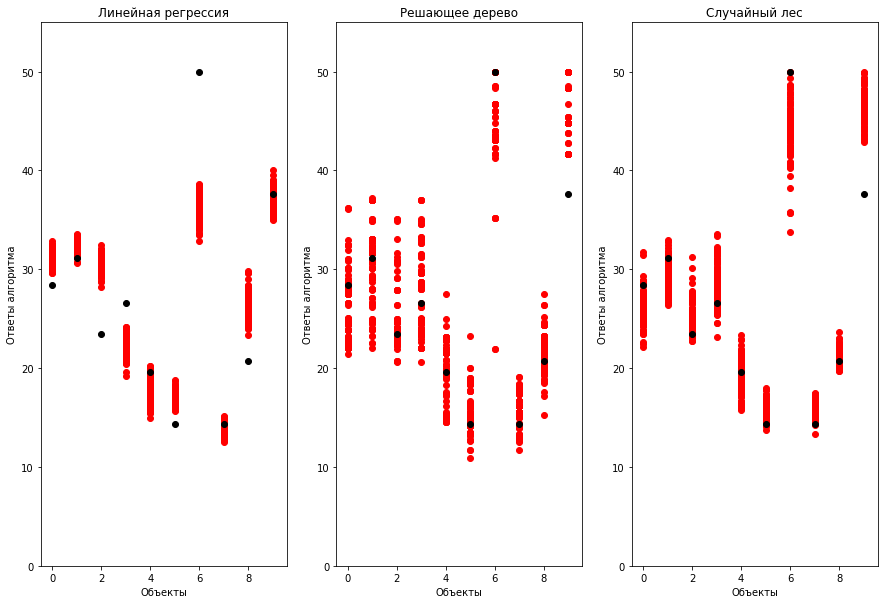

In [154]:
#fig, ax = plt.subplots(1, 3)
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title='Линейная регрессия')
plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title='Решающее дерево')
plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, title='Случайный лес')
plt.show()

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here: линейная регрессия - большое смещение, малый разброс. Решающее дерево - малое смещение, большой разброс. Случайный лес - малое смещение, (сравнительно) малый разброс.**

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('application_train.csv')
y = df.pop('TARGET')
df.shape

(215257, 121)

In [4]:
df

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,239009,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
215253,399937,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
215254,253016,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0
215255,270275,Revolving loans,M,Y,Y,1,180000.0,270000.0,13500.0,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,215257.000000,215257.000000,2.152570e+05,2.152570e+05,215249.000000,2.150580e+05,215257.000000,215257.000000,215257.000000,215257.000000,...,215257.000000,215257.000000,215257.000000,215257.000000,186107.000000,186107.000000,186107.000000,186107.000000,186107.000000,186107.000000
mean,278236.387137,0.416637,1.685568e+05,5.994960e+05,27119.681762,5.388269e+05,0.020869,-16033.152241,63737.365791,-4979.871219,...,0.008060,0.000581,0.000469,0.000311,0.006416,0.006647,0.034260,0.267319,0.266030,1.899429
std,102885.029589,0.719695,1.058557e+05,4.028989e+05,14522.021876,3.698161e+05,0.013829,4361.858115,141210.765298,3522.665372,...,0.089416,0.024091,0.021656,0.017640,0.083910,0.106599,0.205137,0.913343,0.614033,1.870725
min,100003.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-23416.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189025.000000,0.000000,1.125000e+05,2.700000e+05,16506.000000,2.385000e+05,0.010006,-19681.000000,-2760.000000,-7478.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278215.000000,0.000000,1.440000e+05,5.148675e+05,24903.000000,4.500000e+05,0.018850,-15749.000000,-1214.000000,-4495.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367388.000000,1.000000,2.025000e+05,8.086500e+05,34650.000000,6.795000e+05,0.028663,-12410.000000,-290.000000,-2001.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,19.000000,1.350000e+07,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,3.000000,9.000000,8.000000,27.000000,19.000000,25.000000


Отсортируем по количеству не nan полей.

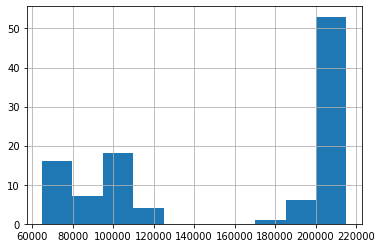

In [6]:
df.describe().sort_values(by='count', axis=1).iloc[0].hist()

Выбросим столбцы, у которых слишком много пропусков.

In [7]:
_t = df.describe().sort_values(by='count', axis=1).iloc[0]
_t = _t[_t > 25000]
df = df[_t.keys()]

In [8]:
df.head()

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,FLOORSMIN_AVG,...,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,FLAG_DOCUMENT_2,FLAG_CONT_MOBILE,SK_ID_CURR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,-2087,-8599.0,-2062,-14653,0.032561,0,1,247330
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,-172,-348.0,-2246,-13995,0.007114,0,1,425716
2,0.3352,0.3331,0.3361,0.0,0.0,0.0,0.5739,0.5253,0.5344,0.375,...,1,1,-4026,-6306.0,-1335,-21687,0.022625,0,1,331625
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,-1201,-742.0,-2292,-13071,0.006629,0,1,455397
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,-3112,-169.0,365243,-19666,0.046220,0,1,449114


Посмотрим типы.

In [9]:
df.dtypes

COMMONAREA_MEDI               float64
COMMONAREA_AVG                float64
COMMONAREA_MODE               float64
NONLIVINGAPARTMENTS_MODE      float64
NONLIVINGAPARTMENTS_AVG       float64
                               ...   
DAYS_BIRTH                      int64
REGION_POPULATION_RELATIVE    float64
FLAG_DOCUMENT_2                 int64
FLAG_CONT_MOBILE                int64
SK_ID_CURR                      int64
Length: 105, dtype: object

Заполним средним.

In [10]:
df.fillna(df.mean(), inplace=True)

C:\conda\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Выбросим столбец с ID.

In [11]:
df.drop(columns=['SK_ID_CURR'], inplace=True)

C:\conda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [14]:
df.head()

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,FLOORSMIN_AVG,...,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,FLAG_DOCUMENT_2,FLAG_CONT_MOBILE
0,0.044569,0.04462,0.042499,0.008126,0.008885,0.008703,0.105615,0.100884,0.101995,0.232182,...,0,1,1,-2087,-8599.0,-2062,-14653,0.032561,0,1
1,0.044569,0.04462,0.042499,0.008126,0.008885,0.008703,0.105615,0.100884,0.101995,0.232182,...,1,1,1,-172,-348.0,-2246,-13995,0.007114,0,1
2,0.335200,0.33310,0.336100,0.000000,0.000000,0.000000,0.573900,0.525300,0.534400,0.375000,...,0,1,1,-4026,-6306.0,-1335,-21687,0.022625,0,1
3,0.044569,0.04462,0.042499,0.008126,0.008885,0.008703,0.105615,0.100884,0.101995,0.232182,...,1,1,1,-1201,-742.0,-2292,-13071,0.006629,0,1
4,0.044569,0.04462,0.042499,0.008126,0.008885,0.008703,0.105615,0.100884,0.101995,0.232182,...,0,0,1,-3112,-169.0,365243,-19666,0.046220,0,1


**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Почему получилась заметная разница в качестве?**

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [15]:
nunique_numbers = { x : df[x].nunique() for x in df.columns }

In [16]:
nunique_numbers

{'COMMONAREA_MEDI': 2967,
 'COMMONAREA_AVG': 2954,
 'COMMONAREA_MODE': 2905,
 'NONLIVINGAPARTMENTS_MODE': 154,
 'NONLIVINGAPARTMENTS_AVG': 354,
 'NONLIVINGAPARTMENTS_MEDI': 194,
 'LIVINGAPARTMENTS_MODE': 712,
 'LIVINGAPARTMENTS_AVG': 1760,
 'LIVINGAPARTMENTS_MEDI': 1057,
 'FLOORSMIN_AVG': 285,
 'FLOORSMIN_MEDI': 48,
 'FLOORSMIN_MODE': 26,
 'YEARS_BUILD_MEDI': 149,
 'YEARS_BUILD_AVG': 147,
 'YEARS_BUILD_MODE': 152,
 'OWN_CAR_AGE': 60,
 'LANDAREA_MEDI': 3383,
 'LANDAREA_AVG': 3354,
 'LANDAREA_MODE': 3389,
 'BASEMENTAREA_MEDI': 3606,
 'BASEMENTAREA_AVG': 3617,
 'BASEMENTAREA_MODE': 3670,
 'EXT_SOURCE_1': 84048,
 'NONLIVINGAREA_MEDI': 3080,
 'NONLIVINGAREA_AVG': 3051,
 'NONLIVINGAREA_MODE': 3078,
 'ELEVATORS_AVG': 246,
 'ELEVATORS_MODE': 27,
 'ELEVATORS_MEDI': 47,
 'APARTMENTS_MODE': 737,
 'APARTMENTS_AVG': 2194,
 'APARTMENTS_MEDI': 1112,
 'ENTRANCES_MODE': 31,
 'ENTRANCES_MEDI': 46,
 'ENTRANCES_AVG': 268,
 'LIVINGAREA_MODE': 5060,
 'LIVINGAREA_AVG': 4976,
 'LIVINGAREA_MEDI': 5052,
 'FLOOR

Выбросим явно категориальные признаки (в задании требуется обучать на вещественных).

In [17]:
non_cat_features = [x for x in nunique_numbers.keys() if nunique_numbers[x] > 25]

In [18]:
X_train_noncat = X_train[non_cat_features]
X_test_noncat = X_test[non_cat_features]

In [19]:
from catboost import CatBoostClassifier

In [271]:
clf = CatBoostClassifier()

In [272]:
%%time
clf.fit(X_train_noncat, y_train)

Learning rate set to 0.069265
0:	learn: 0.6227427	total: 29.5ms	remaining: 29.4s
1:	learn: 0.5642401	total: 51.9ms	remaining: 25.9s
2:	learn: 0.5166151	total: 74ms	remaining: 24.6s
3:	learn: 0.4758402	total: 96.2ms	remaining: 24s
4:	learn: 0.4428974	total: 119ms	remaining: 23.6s
5:	learn: 0.4136455	total: 141ms	remaining: 23.4s
6:	learn: 0.3912918	total: 164ms	remaining: 23.3s
7:	learn: 0.3722653	total: 186ms	remaining: 23.1s
8:	learn: 0.3549327	total: 211ms	remaining: 23.2s
9:	learn: 0.3397476	total: 235ms	remaining: 23.3s
10:	learn: 0.3292503	total: 259ms	remaining: 23.3s
11:	learn: 0.3188073	total: 283ms	remaining: 23.3s
12:	learn: 0.3103595	total: 306ms	remaining: 23.2s
13:	learn: 0.3028593	total: 330ms	remaining: 23.2s
14:	learn: 0.2960028	total: 354ms	remaining: 23.3s
15:	learn: 0.2907074	total: 378ms	remaining: 23.2s
16:	learn: 0.2856500	total: 402ms	remaining: 23.3s
17:	learn: 0.2821158	total: 426ms	remaining: 23.2s
18:	learn: 0.2788546	total: 449ms	remaining: 23.2s
19:	learn: 

163:	learn: 0.2470540	total: 3.89s	remaining: 19.8s
164:	learn: 0.2469955	total: 3.91s	remaining: 19.8s
165:	learn: 0.2469442	total: 3.94s	remaining: 19.8s
166:	learn: 0.2469032	total: 3.96s	remaining: 19.8s
167:	learn: 0.2468609	total: 3.99s	remaining: 19.7s
168:	learn: 0.2468303	total: 4.01s	remaining: 19.7s
169:	learn: 0.2467898	total: 4.03s	remaining: 19.7s
170:	learn: 0.2467587	total: 4.05s	remaining: 19.7s
171:	learn: 0.2467271	total: 4.08s	remaining: 19.6s
172:	learn: 0.2466812	total: 4.1s	remaining: 19.6s
173:	learn: 0.2466373	total: 4.12s	remaining: 19.6s
174:	learn: 0.2466008	total: 4.15s	remaining: 19.5s
175:	learn: 0.2465736	total: 4.17s	remaining: 19.5s
176:	learn: 0.2465151	total: 4.19s	remaining: 19.5s
177:	learn: 0.2464659	total: 4.21s	remaining: 19.5s
178:	learn: 0.2464345	total: 4.24s	remaining: 19.4s
179:	learn: 0.2463792	total: 4.26s	remaining: 19.4s
180:	learn: 0.2463142	total: 4.28s	remaining: 19.4s
181:	learn: 0.2462761	total: 4.31s	remaining: 19.4s
182:	learn: 0

325:	learn: 0.2407296	total: 7.75s	remaining: 16s
326:	learn: 0.2407165	total: 7.77s	remaining: 16s
327:	learn: 0.2406920	total: 7.79s	remaining: 16s
328:	learn: 0.2406339	total: 7.81s	remaining: 15.9s
329:	learn: 0.2405975	total: 7.84s	remaining: 15.9s
330:	learn: 0.2405575	total: 7.86s	remaining: 15.9s
331:	learn: 0.2405332	total: 7.88s	remaining: 15.9s
332:	learn: 0.2405036	total: 7.9s	remaining: 15.8s
333:	learn: 0.2404737	total: 7.93s	remaining: 15.8s
334:	learn: 0.2404388	total: 7.95s	remaining: 15.8s
335:	learn: 0.2404186	total: 7.97s	remaining: 15.8s
336:	learn: 0.2403913	total: 8s	remaining: 15.7s
337:	learn: 0.2403578	total: 8.02s	remaining: 15.7s
338:	learn: 0.2403233	total: 8.04s	remaining: 15.7s
339:	learn: 0.2402903	total: 8.07s	remaining: 15.7s
340:	learn: 0.2402395	total: 8.09s	remaining: 15.6s
341:	learn: 0.2402055	total: 8.12s	remaining: 15.6s
342:	learn: 0.2401841	total: 8.14s	remaining: 15.6s
343:	learn: 0.2401545	total: 8.16s	remaining: 15.6s
344:	learn: 0.2401180	

485:	learn: 0.2353043	total: 11.5s	remaining: 12.1s
486:	learn: 0.2352779	total: 11.5s	remaining: 12.1s
487:	learn: 0.2352290	total: 11.5s	remaining: 12.1s
488:	learn: 0.2352083	total: 11.5s	remaining: 12.1s
489:	learn: 0.2351702	total: 11.6s	remaining: 12s
490:	learn: 0.2351477	total: 11.6s	remaining: 12s
491:	learn: 0.2351397	total: 11.6s	remaining: 12s
492:	learn: 0.2351181	total: 11.6s	remaining: 12s
493:	learn: 0.2350721	total: 11.7s	remaining: 11.9s
494:	learn: 0.2350542	total: 11.7s	remaining: 11.9s
495:	learn: 0.2350211	total: 11.7s	remaining: 11.9s
496:	learn: 0.2349909	total: 11.7s	remaining: 11.9s
497:	learn: 0.2349478	total: 11.8s	remaining: 11.8s
498:	learn: 0.2349045	total: 11.8s	remaining: 11.8s
499:	learn: 0.2348802	total: 11.8s	remaining: 11.8s
500:	learn: 0.2348589	total: 11.8s	remaining: 11.8s
501:	learn: 0.2348024	total: 11.8s	remaining: 11.8s
502:	learn: 0.2347827	total: 11.9s	remaining: 11.7s
503:	learn: 0.2347472	total: 11.9s	remaining: 11.7s
504:	learn: 0.234706

647:	learn: 0.2306133	total: 15.3s	remaining: 8.29s
648:	learn: 0.2305964	total: 15.3s	remaining: 8.27s
649:	learn: 0.2305674	total: 15.3s	remaining: 8.24s
650:	learn: 0.2305364	total: 15.3s	remaining: 8.22s
651:	learn: 0.2305149	total: 15.4s	remaining: 8.2s
652:	learn: 0.2304821	total: 15.4s	remaining: 8.17s
653:	learn: 0.2304450	total: 15.4s	remaining: 8.15s
654:	learn: 0.2304077	total: 15.4s	remaining: 8.12s
655:	learn: 0.2303827	total: 15.4s	remaining: 8.1s
656:	learn: 0.2303548	total: 15.5s	remaining: 8.08s
657:	learn: 0.2303322	total: 15.5s	remaining: 8.05s
658:	learn: 0.2303132	total: 15.5s	remaining: 8.03s
659:	learn: 0.2302793	total: 15.5s	remaining: 8.01s
660:	learn: 0.2302397	total: 15.6s	remaining: 7.98s
661:	learn: 0.2302236	total: 15.6s	remaining: 7.96s
662:	learn: 0.2301906	total: 15.6s	remaining: 7.94s
663:	learn: 0.2301597	total: 15.6s	remaining: 7.91s
664:	learn: 0.2301319	total: 15.7s	remaining: 7.89s
665:	learn: 0.2301039	total: 15.7s	remaining: 7.87s
666:	learn: 0.

810:	learn: 0.2261124	total: 19.1s	remaining: 4.45s
811:	learn: 0.2260897	total: 19.1s	remaining: 4.43s
812:	learn: 0.2260620	total: 19.1s	remaining: 4.4s
813:	learn: 0.2260546	total: 19.2s	remaining: 4.38s
814:	learn: 0.2260229	total: 19.2s	remaining: 4.36s
815:	learn: 0.2259836	total: 19.2s	remaining: 4.33s
816:	learn: 0.2259556	total: 19.2s	remaining: 4.31s
817:	learn: 0.2259168	total: 19.3s	remaining: 4.29s
818:	learn: 0.2258981	total: 19.3s	remaining: 4.26s
819:	learn: 0.2258754	total: 19.3s	remaining: 4.24s
820:	learn: 0.2258265	total: 19.3s	remaining: 4.21s
821:	learn: 0.2258009	total: 19.4s	remaining: 4.19s
822:	learn: 0.2257733	total: 19.4s	remaining: 4.17s
823:	learn: 0.2257458	total: 19.4s	remaining: 4.14s
824:	learn: 0.2257191	total: 19.4s	remaining: 4.12s
825:	learn: 0.2256796	total: 19.4s	remaining: 4.1s
826:	learn: 0.2256543	total: 19.5s	remaining: 4.07s
827:	learn: 0.2256292	total: 19.5s	remaining: 4.05s
828:	learn: 0.2256031	total: 19.5s	remaining: 4.03s
829:	learn: 0.

971:	learn: 0.2220344	total: 22.9s	remaining: 660ms
972:	learn: 0.2220060	total: 22.9s	remaining: 636ms
973:	learn: 0.2219807	total: 22.9s	remaining: 612ms
974:	learn: 0.2219697	total: 23s	remaining: 589ms
975:	learn: 0.2219268	total: 23s	remaining: 565ms
976:	learn: 0.2219084	total: 23s	remaining: 542ms
977:	learn: 0.2218713	total: 23s	remaining: 518ms
978:	learn: 0.2218449	total: 23.1s	remaining: 495ms
979:	learn: 0.2218304	total: 23.1s	remaining: 471ms
980:	learn: 0.2217980	total: 23.1s	remaining: 448ms
981:	learn: 0.2217770	total: 23.1s	remaining: 424ms
982:	learn: 0.2217723	total: 23.1s	remaining: 400ms
983:	learn: 0.2217431	total: 23.2s	remaining: 377ms
984:	learn: 0.2217132	total: 23.2s	remaining: 353ms
985:	learn: 0.2216914	total: 23.2s	remaining: 330ms
986:	learn: 0.2216759	total: 23.2s	remaining: 306ms
987:	learn: 0.2216618	total: 23.3s	remaining: 283ms
988:	learn: 0.2216293	total: 23.3s	remaining: 259ms
989:	learn: 0.2216093	total: 23.3s	remaining: 236ms
990:	learn: 0.221590

In [273]:
y_pred_catboost = clf.predict_proba(X_test_noncat)[:, 1]

Посмотрим качество CatBoostClassifier.

In [35]:
from sklearn.metrics import precision_recall_curve, auc

In [36]:
def pr_auc_score(y_proba, y_true):
    lr_precision, lr_recall, _ = precision_recall_curve(y_true, y_proba)
    return auc(lr_recall, lr_precision)

In [276]:
pr_auc_score(y_pred_catboost, y_test)

0.23266324131505872

Теперь обучим LGBM.

In [282]:
import lightgbm as lgb

In [283]:
lgb_train = lgb.Dataset(X_train_noncat, y_train)

In [284]:
%%time
clf_lgb = lgb.train({}, train_set=lgb_train)

Wall time: 843 ms


In [285]:
y_pred_lgbm = clf_lgb.predict(X_test_noncat)

Посмотрим качество LGBM.

In [286]:
pr_auc_score(y_pred_lgbm, y_test)

0.23513525131006136

**Your answer here:** сложно сказать, почему в нашем конкретном случае один алгоритм работает лучше другого. Возможно, у LGBM чуть более удачно выбраны гиперпараметры по умолчанию. Например, у LGBM неограниченная глубина дерева по умолчанию, а у CatBoost равная 6. Также CatBoost по умолчанию имеет 1000 деревьев (LGBM - 100), что может вести к переобучению. Однако стоит заметить разницу во времени обучения: LGBM гораздо быстрее работает, поскольку при построении деревьев он не ищет точое решение для разбиения, а ограничивается приближенным, в то время как CatBoost ищет точное разбиение.

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть в [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb) про библиотеки.

**Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

Перебор для LGBM

In [20]:
from sklearn.model_selection import GridSearchCV

In [288]:
params = {
    'max_depth' : [None, 3, 10, 15],
    'n_estimators' : [100, 500, 1000],
    'learning_rate' : [1e-6, 1e-3, 0.1, 1]
}

In [290]:
mdl = lgb.LGBMClassifier()

In [293]:
%%time
grid = GridSearchCV(mdl, params, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train_noncat, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  7.4min finished


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
0.9187544382428872
Wall time: 7min 24s


In [294]:
clf = lgb.train({'max_depth' : 3, 'learning_rate' : 0.1, 'n_estimators' : 500}, train_set=lgb_train)

C:\conda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [295]:
y_pred = clf.predict(X_test_noncat)

In [296]:
pr_auc_score(y_pred, y_test)

0.23622501725871337

Перебор для CatBoost (поскольку CatBoost гораздо дольше обучается, сократим количество перебираемых параметров).

In [25]:
params = {
    'max_depth' : [None, 3, 10, 15],
    'n_estimators' : [100, 500, 1000],
    'silent' : [True]
}

In [26]:
mdl = CatBoostClassifier()

In [28]:
%%time
grid = GridSearchCV(mdl, params, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train_noncat, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 209.8min finished


{'max_depth': 3, 'n_estimators': 500, 'silent': True}
0.9187809847423994
Wall time: 3h 29min 58s


In [31]:
clf = CatBoostClassifier(max_depth= 3, n_estimators = 500)

In [32]:
clf.fit(X_train_noncat, y_train)

Learning rate set to 0.128449
0:	learn: 0.5697372	total: 16.5ms	remaining: 8.23s
1:	learn: 0.4834793	total: 31.6ms	remaining: 7.87s
2:	learn: 0.4204155	total: 47.5ms	remaining: 7.87s
3:	learn: 0.3802508	total: 62.8ms	remaining: 7.79s
4:	learn: 0.3491652	total: 78.3ms	remaining: 7.75s
5:	learn: 0.3263273	total: 94.6ms	remaining: 7.79s
6:	learn: 0.3093800	total: 111ms	remaining: 7.8s
7:	learn: 0.2971808	total: 126ms	remaining: 7.73s
8:	learn: 0.2885814	total: 141ms	remaining: 7.7s
9:	learn: 0.2815655	total: 156ms	remaining: 7.64s
10:	learn: 0.2766357	total: 173ms	remaining: 7.71s
11:	learn: 0.2731167	total: 192ms	remaining: 7.79s
12:	learn: 0.2699095	total: 210ms	remaining: 7.86s
13:	learn: 0.2677870	total: 226ms	remaining: 7.84s
14:	learn: 0.2658394	total: 242ms	remaining: 7.82s
15:	learn: 0.2644389	total: 258ms	remaining: 7.8s
16:	learn: 0.2628772	total: 274ms	remaining: 7.79s
17:	learn: 0.2617987	total: 290ms	remaining: 7.77s
18:	learn: 0.2611289	total: 306ms	remaining: 7.76s
19:	lear

162:	learn: 0.2493134	total: 2.68s	remaining: 5.54s
163:	learn: 0.2492897	total: 2.69s	remaining: 5.52s
164:	learn: 0.2492568	total: 2.71s	remaining: 5.51s
165:	learn: 0.2492350	total: 2.73s	remaining: 5.49s
166:	learn: 0.2492106	total: 2.75s	remaining: 5.47s
167:	learn: 0.2491906	total: 2.76s	remaining: 5.46s
168:	learn: 0.2491645	total: 2.78s	remaining: 5.44s
169:	learn: 0.2491450	total: 2.8s	remaining: 5.43s
170:	learn: 0.2491194	total: 2.81s	remaining: 5.42s
171:	learn: 0.2490985	total: 2.83s	remaining: 5.4s
172:	learn: 0.2490729	total: 2.85s	remaining: 5.38s
173:	learn: 0.2490361	total: 2.87s	remaining: 5.37s
174:	learn: 0.2490169	total: 2.88s	remaining: 5.36s
175:	learn: 0.2489996	total: 2.9s	remaining: 5.34s
176:	learn: 0.2489784	total: 2.92s	remaining: 5.33s
177:	learn: 0.2489633	total: 2.94s	remaining: 5.32s
178:	learn: 0.2489271	total: 2.96s	remaining: 5.3s
179:	learn: 0.2489096	total: 2.98s	remaining: 5.29s
180:	learn: 0.2488660	total: 2.99s	remaining: 5.28s
181:	learn: 0.24

323:	learn: 0.2460437	total: 5.57s	remaining: 3.03s
324:	learn: 0.2460154	total: 5.59s	remaining: 3.01s
325:	learn: 0.2460009	total: 5.61s	remaining: 2.99s
326:	learn: 0.2459892	total: 5.63s	remaining: 2.98s
327:	learn: 0.2459716	total: 5.64s	remaining: 2.96s
328:	learn: 0.2459610	total: 5.66s	remaining: 2.94s
329:	learn: 0.2459474	total: 5.68s	remaining: 2.92s
330:	learn: 0.2459344	total: 5.7s	remaining: 2.91s
331:	learn: 0.2458956	total: 5.72s	remaining: 2.89s
332:	learn: 0.2458804	total: 5.74s	remaining: 2.88s
333:	learn: 0.2458589	total: 5.75s	remaining: 2.86s
334:	learn: 0.2458493	total: 5.77s	remaining: 2.84s
335:	learn: 0.2458490	total: 5.79s	remaining: 2.83s
336:	learn: 0.2458264	total: 5.8s	remaining: 2.81s
337:	learn: 0.2458157	total: 5.82s	remaining: 2.79s
338:	learn: 0.2457956	total: 5.84s	remaining: 2.77s
339:	learn: 0.2457742	total: 5.86s	remaining: 2.76s
340:	learn: 0.2457594	total: 5.88s	remaining: 2.74s
341:	learn: 0.2457301	total: 5.89s	remaining: 2.72s
342:	learn: 0.

482:	learn: 0.2435900	total: 8.4s	remaining: 296ms
483:	learn: 0.2435667	total: 8.42s	remaining: 278ms
484:	learn: 0.2435551	total: 8.44s	remaining: 261ms
485:	learn: 0.2435363	total: 8.45s	remaining: 244ms
486:	learn: 0.2435084	total: 8.47s	remaining: 226ms
487:	learn: 0.2434933	total: 8.49s	remaining: 209ms
488:	learn: 0.2434839	total: 8.5s	remaining: 191ms
489:	learn: 0.2434731	total: 8.52s	remaining: 174ms
490:	learn: 0.2434561	total: 8.54s	remaining: 157ms
491:	learn: 0.2434407	total: 8.55s	remaining: 139ms
492:	learn: 0.2434260	total: 8.57s	remaining: 122ms
493:	learn: 0.2434108	total: 8.59s	remaining: 104ms
494:	learn: 0.2434027	total: 8.6s	remaining: 86.9ms
495:	learn: 0.2433917	total: 8.62s	remaining: 69.5ms
496:	learn: 0.2433773	total: 8.63s	remaining: 52.1ms
497:	learn: 0.2433549	total: 8.65s	remaining: 34.7ms
498:	learn: 0.2433299	total: 8.66s	remaining: 17.4ms
499:	learn: 0.2433192	total: 8.68s	remaining: 0us


In [33]:
y_pred = clf.predict(X_test_noncat)

In [37]:
pr_auc_score(y_pred, y_test)

0.3323383695074164

**Your answer here: в обоих случаях оптимальным числом деревьев было 500, а глубина 3. Заметим, что CatBoost с подобранными гиперпараметрами показал значительно лучший результат, однако мы затратили гораздо больше времени на их подбор: 3.5 часа против 7 минут для LGBM (как я указывал выше, это связано с тем, что LGBM ищет приблизительное решение, а CatBoost точное)**